In [1]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/')

from benji_girgs import utils, generation, points, fitting, mcmc
import glob
import pandas as pd
import networkit

import networkit as nk


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import pickle

In [2]:
n=1000
tau=2.5
alpha=1.5
desiredAvgDegree=50.0
d=2

g, edges, weights, pts, const = generation.generate_GIRG_nk(
        n, d, tau, alpha,
    desiredAvgDegree=desiredAvgDegree,
    points_type=points.PointsTorus2, c_implementation=True)

pts = np.array(pts)
weights = np.array(weights)

In [3]:
nk.overview(g)

Network Properties:
nodes, edges			1000, 24830
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.049710
clustering coefficient		0.509722
min/max/avg degree		10, 841, 49.660000
degree assortativity		-0.151413
number of connected components	1
size of largest component	1000 (100.00 %)


In [13]:
n = g.numberOfNodes()
tau = utils.powerlaw_fit_graph(g)
# TODO is this a good idea? Or even cap also at 3.0?
tau = max(tau, 2.1)
weights = np.array(generation.generateWeights(n, tau))

c, probs = generation.chung_lu_fit_c(g, weights)
adj = np.triu(np.random.uniform(size=probs.shape) < probs, 1)
g2 = generation.edge_list_to_nk_graph(zip(*np.nonzero(adj)), n)



weights *= 2 * g.numberOfEdges() / np.sum(weights)
networkit.setSeed(seed=42, useThreadId=False)
g3 = networkit.generators.ChungLuGenerator(weights).generate()


g4 = generation.fit_chung_lu(g)


In [14]:
g.numberOfEdges()
g2.numberOfEdges()
g3.numberOfEdges()
g4.numberOfEdges()

24830

24730

23098

24089

In [9]:
np.triu(probs, 1).sum()

24830.00000124212

In [ ]:
nk.overview(g2)
nk.overview(g3)
nk.overview(g4)

Network Properties:
nodes, edges			5000, 12497500
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				1.000000


In [15]:
g4 = generation.fit_chung_lu(g)
nk.overview(g3)

Network Properties:
nodes, edges			5000, 123980
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.009920
clustering coefficient		0.094711
min/max/avg degree		6, 3316, 49.592000
degree assortativity		0.169453
number of connected components	1
size of largest component	5000 (100.00 %)


In [14]:
0.5 * weights.sum()
tau
np.max(weights)

125566.0

2.6194679677510804

14055.971399358914

In [30]:
gnx = nk.nxadapter.nk2nx(g)
A = nx.linalg.adjacency_matrix(gnx).todense()
D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

Iweighting=0.1
M = np.diag(1/D) @ A
M = (1-Iweighting)* M + Iweighting * np.eye(M.shape[0])


######
gamma=1.0
M_tilde = np.diag(1/D) @ A @ np.diag(D**(-gamma))
M_tilde = np.diag(np.array(1 / M_tilde.sum(axis=-1)).squeeze()) @ M_tilde
M_tilde = (1-Iweighting)* M_tilde + Iweighting * np.eye(M_tilde.shape[0])
######


d = 2  # integer??
A = A.astype(np.float32)
# if u~v then E[r_uv] is about such that p_uv=1, i.e. r_uv = (w_u w_v/n)^(1/d)
# Then heat kernel thing says that we want W_ij = exp(-r_ij^2 / T) for some param T
dd = nk.centrality.DegreeCentrality(g).run().scores()
n = g.numberOfNodes()
T = 1.0 # ??
for i, j in g.iterEdges():
    r_ij = (dd[i] * dd[j] / n)**(1/d)
    A[i, j] = np.exp(-r_ij**2 / T)
    A[j, i] = A[i, j]

D = A.sum(axis=1)

M_hk = np.diag(1/D) @ A
M_hk = (1-Iweighting)* M_hk + Iweighting * np.eye(M_hk.shape[0])




def get_t_map(M, i=0, t=10):
    v = np.zeros(M.shape[0]).astype(np.float64)
    v[i] = 1.
    return (v.T @ (np.linalg.matrix_power(M, t))).T

i = 0
while True:
    if np.max(np.abs(pts[i] - np.array([0.5, 0.5]))) > 0.02:
        i += 1
    else:
        break
else:
    raise Exception('couldn\'t find center')

print(pts[i])

# recenter pts about i
# pts2 = pts.copy()
# pts2 = pts2 - pts[i] + np.array([0.5, 0.5])
# pts = pts2



print(weights[i])

[0.51106088 0.49921789]
2.0653636420090677


In [31]:
hm = get_t_map(M, i, 50)
hm2 = (hm - hm.min())/(hm.max() - hm.min())

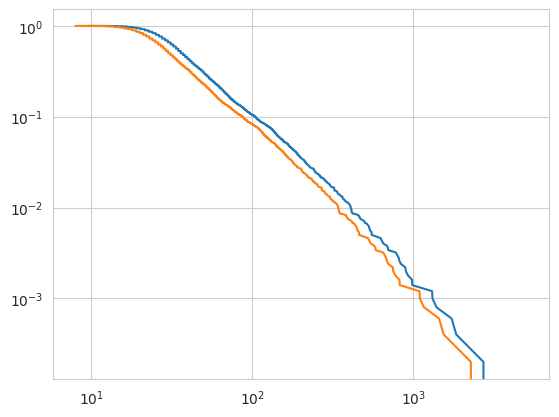

In [33]:
hm_sorted = sorted(hm, reverse=True)
one_minus_cdf = 1. * np.arange(len(hm_sorted)) / (len(hm_sorted) - 1)

plt.plot((3*10**5) * np.array(hm_sorted), one_minus_cdf)
plt.xscale('log')
plt.yscale('log')

dd = sorted(nk.centrality.DegreeCentrality(g).run().scores(), reverse=True)
one_minus_cdf = 1. * np.arange(len(dd)) / (len(dd) - 1)
# plt.figure()
plt.plot(dd, one_minus_cdf)
# plt.xscale('log')
# plt.yscale('log')

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, '2d GIRG RW starting from X. Pt size prop to weight')

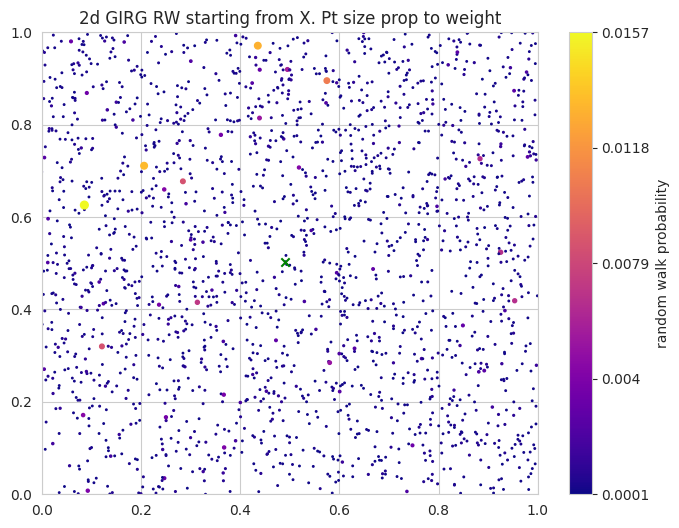

In [11]:
# plt.scatter(pts[:, 0], pts[:, 1], s=10.0, c=hm2)
# plt.scatter(pts[:, 0], pts[:, 1], s=utils.percentileify(weights)*10 + 1, c=hm2)
hm2 = (hm - hm.min())/(hm.max() - hm.min())
plt.figure(figsize=(8, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=weights*30/weights.max() + 1, c=hm2, cmap='plasma')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)


cbar = plt.colorbar()
cbar.set_label('random walk probability')
tick_locs = np.linspace(start=0, stop=1, num=5)  # e.g., 5 ticks
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.round(np.linspace(start=hm.min(), stop=hm.max(), num=5), 4))

plt.title(f'2d GIRG RW starting from X. Pt size prop to weight')
plt.scatter(pts[i, 0], pts[i, 1], marker='x', color='g')
plt.show()


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, '2d GIRG RW starting from X: small weight pts')

<Figure size 640x480 with 0 Axes>

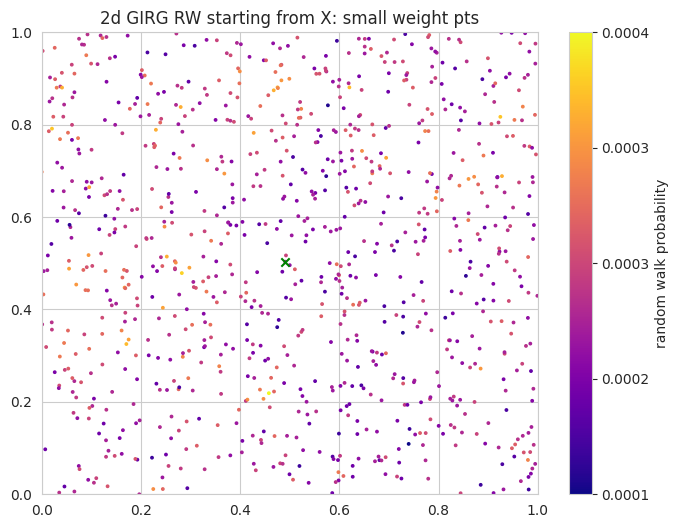

In [12]:
subset = weights < 1.5
plt.figure()
hm2 = (hm[subset] - hm[subset].min())/(hm[subset].max() - hm[subset].min())
plt.figure(figsize=(8, 6))
plt.scatter(pts[subset, 0], pts[subset, 1], s=3, c=hm2, cmap='plasma')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar()
cbar.set_label('random walk probability')
tick_locs = np.linspace(start=0, stop=1, num=5)  # e.g., 5 ticks
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.round(np.linspace(start=hm[subset].min(), stop=hm[subset].max(), num=5), 4))


plt.title(f'2d GIRG RW starting from X: small weight pts')
plt.scatter(pts[i, 0], pts[i, 1], marker='x', color='g')
plt.show()


In [13]:
hm = get_t_map(M_tilde, i, 6)

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, '2d GIRG deg scaled RW starting from X')

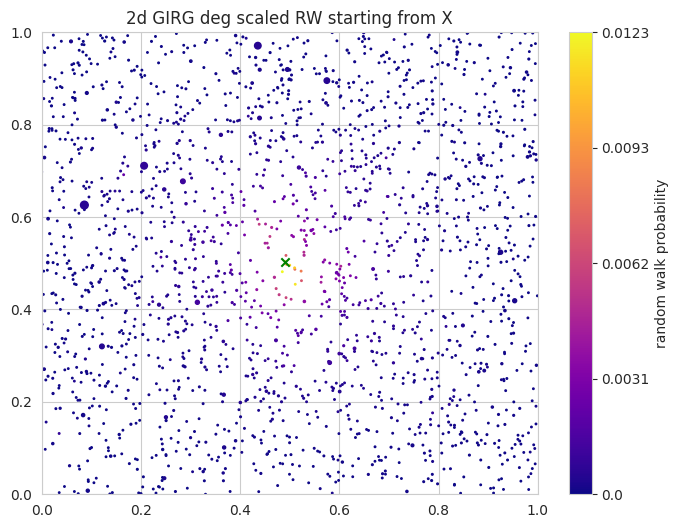

In [14]:
# plt.scatter(pts[:, 0], pts[:, 1], s=10.0, c=hm2)
# plt.scatter(pts[:, 0], pts[:, 1], s=utils.percentileify(weights)*10 + 1, c=hm2)
hm2 = (hm - hm.min())/(hm.max() - hm.min())
plt.figure(figsize=(8, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=weights*30/weights.max() + 1, c=hm2, cmap='plasma')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar()
cbar.set_label('random walk probability')
tick_locs = np.linspace(start=0, stop=1, num=5)  # e.g., 5 ticks
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.round(np.linspace(start=hm.min(), stop=hm.max(), num=5), 4))

plt.title(f'2d GIRG deg scaled RW starting from X')
plt.scatter(pts[i, 0], pts[i, 1], marker='x', color='g')
plt.show()


In [125]:
hm = get_t_map(M_hk, i, 6)

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, '2d GIRG heat kernel scaled RW starting from X')

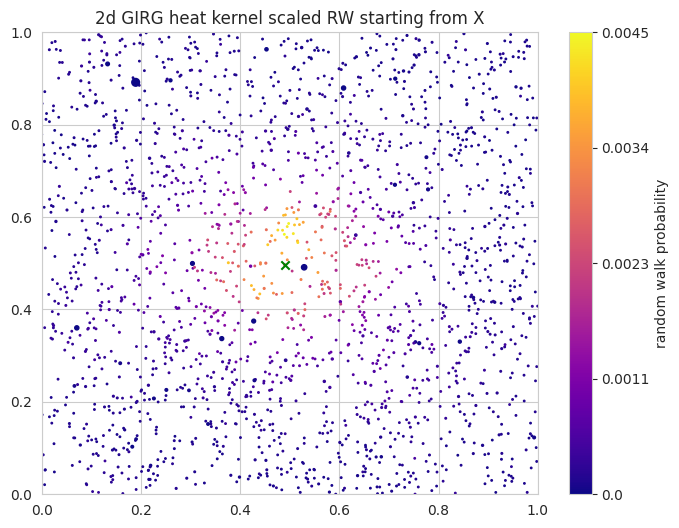

In [126]:
# plt.scatter(pts[:, 0], pts[:, 1], s=10.0, c=hm2)
# plt.scatter(pts[:, 0], pts[:, 1], s=utils.percentileify(weights)*10 + 1, c=hm2)
hm2 = (hm - hm.min())/(hm.max() - hm.min())
plt.figure(figsize=(8, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=weights*30/weights.max() + 1, c=hm2, cmap='plasma')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar()
cbar.set_label('random walk probability')
tick_locs = np.linspace(start=0, stop=1, num=5)  # e.g., 5 ticks
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.round(np.linspace(start=hm.min(), stop=hm.max(), num=5), 4))

plt.title(f'2d GIRG heat kernel scaled RW starting from X')
plt.scatter(pts[i, 0], pts[i, 1], marker='x', color='g')
plt.show()


In [ ]:
######
gamma=0.9
M = M @ np.diag(D**(-gamma))
M = np.diag(np.array(1 / M.sum(axis=-1)).squeeze()) @ M
######

In [44]:
pts[0], pts[1], pts[2], pts[3]

(array([0.16946436, 0.59618693]),
 array([0.44642566, 0.56789932]),
 array([0.86191416, 0.32927426]),
 array([0.20693182, 0.57731573]))

In [ ]:
pts[1]

(array([999.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.00104167, 0.00208333, 0.003125  , 0.00416667,
        0.00520833, 0.00625   , 0.00729167, 0.00833333, 0.009375  ,
        0.01041667, 0.01145833, 0.0125    , 0.01354167, 0.01458333,
        0.015625  , 0.01666667, 0.01770833, 0.01875   , 0.01979167,
        0.02083333, 0.021875  , 0.02291667, 0.02395833, 0.025     ,
        0.02604167, 0.02708333, 0.028125  , 0.02916667, 0.03020833,
        0.03125   ]),
 <BarContainer object of 30 artists>)

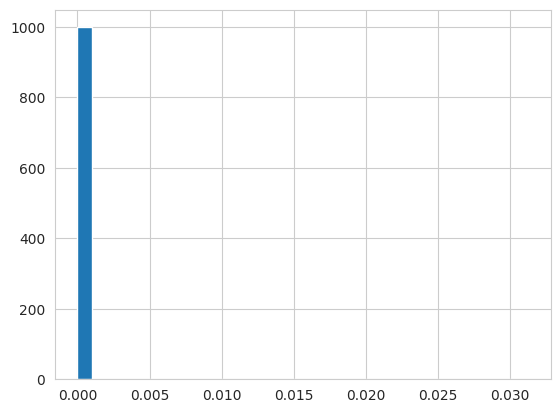

In [21]:
plt.hist(hm, bins=30)

In [22]:
sorted(hm)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [34]:
M@ M

array([[2.55359197e-01, 1.27001387e-04, 1.42549297e-04, ...,
        2.47009395e-05, 1.79906710e-05, 1.02324235e-05],
       [1.27001387e-03, 2.54798667e-01, 9.12059672e-05, ...,
        1.38888889e-05, 9.12059672e-05, 1.82481752e-05],
       [6.95362423e-04, 4.44907157e-05, 2.54227542e-01, ...,
        1.07190492e-04, 5.54971435e-05, 9.02023619e-05],
       ...,
       [1.76435282e-04, 9.92063492e-06, 1.56957506e-04, ...,
        2.54982738e-01, 9.92063492e-06, 1.05986691e-03],
       [1.79906710e-04, 9.12059672e-05, 1.13769144e-04, ...,
        1.38888889e-05, 2.54741117e-01, 1.82481752e-05],
       [6.60156358e-05, 1.17730162e-05, 1.19299898e-04, ...,
        9.57299147e-04, 1.17730162e-05, 2.54902933e-01]])

In [28]:
spsp = nk.distance.SPSP(g, [0]).run()


In [32]:
spsp.getDistance(0, 2)

2.0